In [1]:
import os
import torch
from torch import nn
import pandas as pd
from matplotlib import pyplot as plt
from torch.utils.data import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
data_dir = "/home/arvid/Data/entso-e/"
raw_dataset = pd.read_csv(data_dir + "train.csv")
raw_dataset

,Load [MW],Time [s],Country
0,70929.0,2015-01-01 00:00:00,fr
1,69773.0,2015-01-01 01:00:00,fr
2,66417.0,2015-01-01 02:00:00,fr
3,64182.0,2015-01-01 03:00:00,fr
4,63859.0,2015-01-01 04:00:00,fr
...,...,...,...
368251,35675.0,2017-12-31 19:00:00,be
368252,34505.0,2017-12-31 20:00:00,be
368253,35088.0,2017-12-31 21:00:00,be
368254,35950.0,2017-12-31 22:00:00,be


In [3]:
grouped_dataset = raw_dataset.groupby('Country')
print(next(iter(grouped_dataset)))

countries = []
for country, df in grouped_dataset['Load [MW]']:
    countries.append(torch.tensor(df.to_numpy(), dtype=torch.float))

dataset = torch.stack(countries)
dataset.shape

('at',         Load [MW]             Time [s] Country
263040    23854.0  2015-01-01 00:00:00      at
263041    22905.0  2015-01-01 01:00:00      at
263042    21388.0  2015-01-01 02:00:00      at
263043    20996.0  2015-01-01 03:00:00      at
263044    21234.0  2015-01-01 04:00:00      at
...           ...                  ...     ...
289339    26960.0  2017-12-31 19:00:00      at
289340    25653.0  2017-12-31 20:00:00      at
289341    26231.0  2017-12-31 21:00:00      at
289342    25339.0  2017-12-31 22:00:00      at
289343    24619.0  2017-12-31 23:00:00      at

[26304 rows x 3 columns])


torch.Size([14, 26304])

(4, 2)


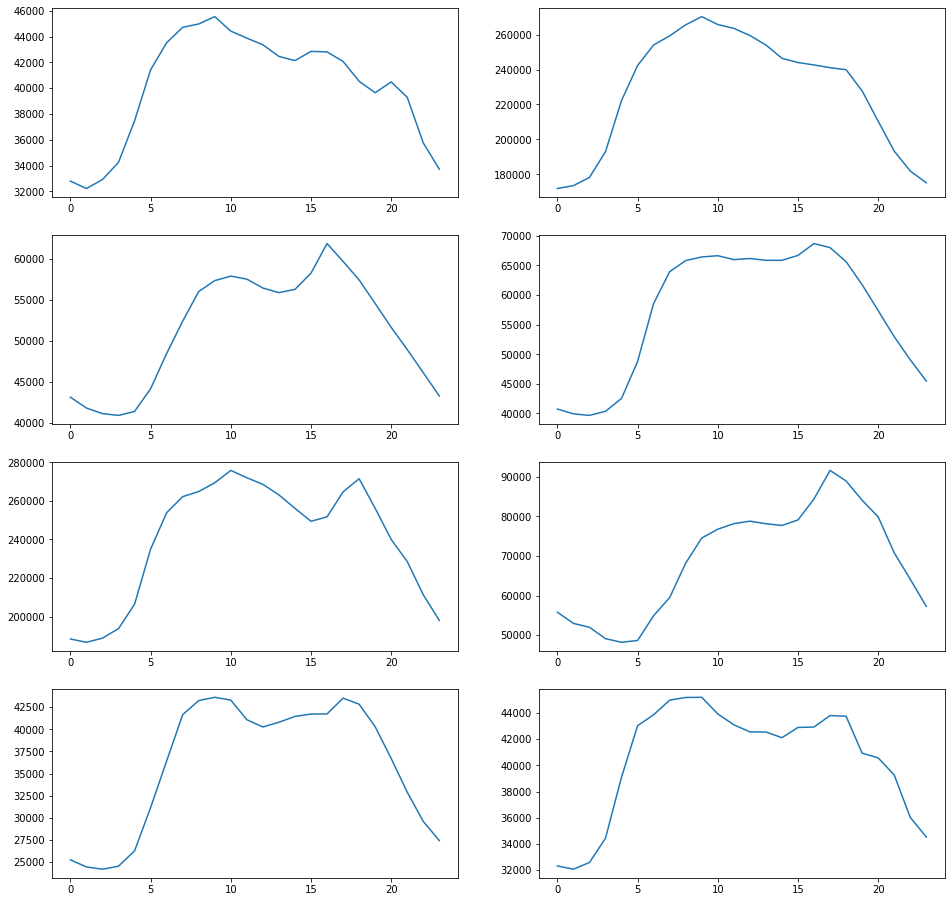

In [4]:
country_nr = dataset.shape[0]
day_nr = dataset.shape[1] // 24

from random import randrange
fig, axs = plt.subplots(4, 2, figsize=(16,16))
for n in range(8):
    country = randrange(country_nr)
    day = randrange(day_nr)
    data = dataset[country, 24*day:24*day+24]
    axs[n%4, n//4].plot(data)

In [5]:
class CustomLoadDataset(Dataset):
    def __init__(self, data_file, historic_window, forecast_horizon, device=None, normalize=True):
        # Input sequence length and output (forecast) sequence length
        self.historic_window = historic_window
        self.forecast_horizon = forecast_horizon

        # Load Data from csv to Pandas Dataframe
        raw_data = pd.read_csv(data_file, delimiter=',')

        # Group data by city
        groups = raw_data.groupby('Country')
        countries = []
        for country, df in groups['Load [MW]']:
            countries.append(torch.tensor(df.to_numpy(), dtype=torch.float))

        # Generate data tensor and metadata
        self.dataset = torch.stack(countries)
        self.country_nr = self.dataset.shape[0]
        self.samples_per_country = self.dataset.shape[1] - self.historic_window - self.forecast_horizon

        # Normalize each city to [0,1]
        if normalize is True:
            self.data_min = torch.min(self.dataset, dim=-1)[0]
            self.data_max = torch.max(self.dataset, dim=-1)[0]
            normlization = (self.data_max - self.data_min).unsqueeze(-1)
            self.dataset = (self.dataset - self.data_min.unsqueeze(-1)) / normlization

        self.dataset = self.dataset.to(device)

    def __len__(self):
        return self.country_nr * self.samples_per_country

    def __getitem__(self, idx):
        # translate idx (day nr) to array index
        country_idx = idx // self.samples_per_country
        hour_idx = idx % self.samples_per_country
        x = self.dataset[country_idx, hour_idx:hour_idx+self.historic_window].unsqueeze(dim=1)
        y = self.dataset[country_idx, hour_idx+self.historic_window:
                                   hour_idx+self.historic_window + self.forecast_horizon].unsqueeze(dim=1)

        return x, y

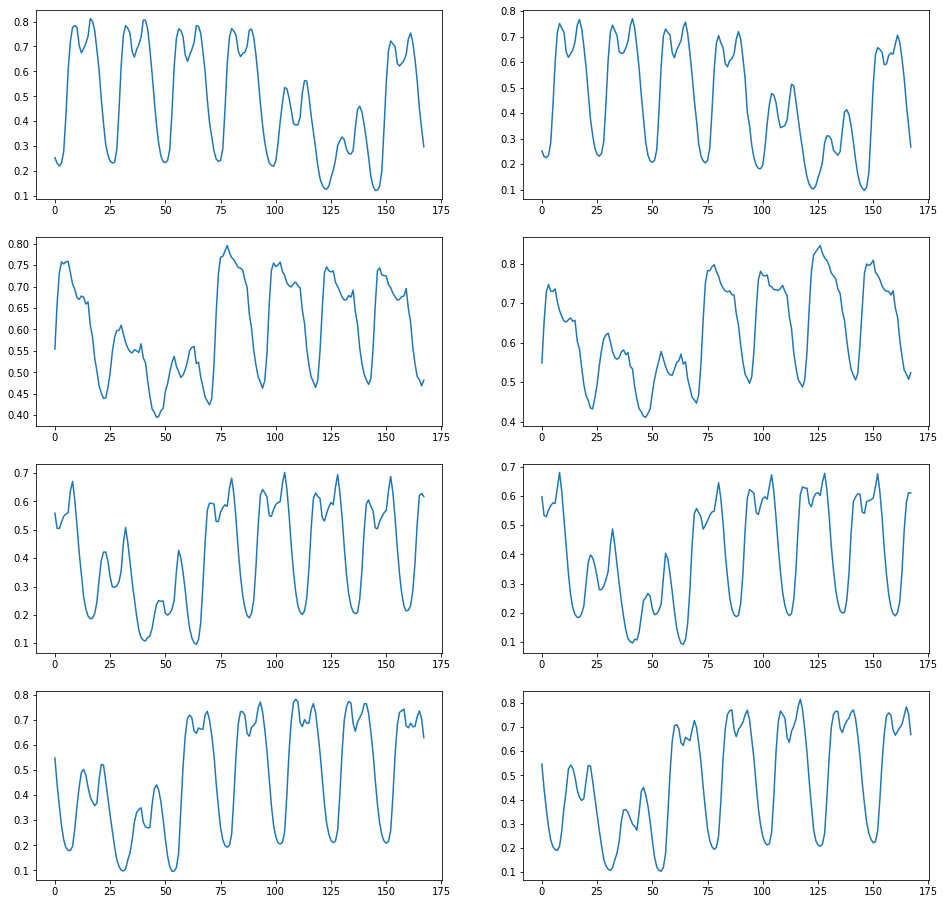

In [10]:
historic_window = 7*24
forecast_window = 7*24

train_set = CustomLoadDataset(data_dir + "train.csv", historic_window, forecast_window, device)

fig, axs = plt.subplots(4, 2, figsize=(16,16))
sample_nr = len(train_set)
for n in range(4):
    idx = randrange(sample_nr)
    data = train_set[idx]
    axs[n%4, 0].plot(data[0])
    axs[n%4, 1].plot(data[1])
    
# Left sample, right label

In [11]:
class LoadForecaster(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int,
                 num_layer: int = 1, dropout: float = 0, batch_first: bool = True, device: torch.device = None):
        super(LoadForecaster, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layer
        self.device = device

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layer, dropout=dropout, batch_first=batch_first,
                            device=self.device)
        self.fully_connected = nn.Linear(hidden_size, output_size, device=self.device)

    def forward(self, input_sequence, hidden):
        output, hidden = self.lstm(input_sequence, hidden)
        output = self.fully_connected(output)
        return output, hidden

    def init_hidden(self, batch_size):
        hidden_state = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=self.device)
        cell_state = torch.randn(self.num_layers, batch_size, self.hidden_size, device=self.device)

        return hidden_state, cell_state

In [ ]:
historic_window = 7*24
forecast_window = 7*24

batch_size = 64
hidden_nodes = 48

input_size = 1
output_size = 1

n_iterations = 30
learning_rate = 1e-3

In [ ]:
train_set = CustomLoadDataset(data_dir + "train.csv", historic_window, forecast_window, device)
valid_set = CustomLoadDataset(data_dir + "valid.csv", historic_window, forecast_window, device)
test_set = CustomLoadDataset(data_dir + "test.csv", historic_window, forecast_window, device)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
model = LoadForecaster(input_size, hidden_nodes, output_size, device=device)
criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_loss = torch.zeros(n_iterations)
val_loss = torch.zeros(n_iterations)

for epoch in range(n_iterations):
    # training phase
    model.train()
    loader = train_loader

    for input_seq, target_seq in loader:
        hidden = model.init_hidden(batch_size)
        predict, hidden = model(input_seq, hidden)

        loss = criterion(predict, target_seq)
        train_loss[epoch] += loss.item()

        model.zero_grad()
        loss.backward()
        optim.step()

    train_loss[epoch] /= len(loader)

    # validation phase
    model.eval()
    loader = valid_loader
    for input_seq, target_seq in loader:
        with torch.no_grad():
            hidden = model.init_hidden(batch_size)
            predict, hidden = model(input_seq, hidden)

            loss = criterion(predict, target_seq)
            val_loss[epoch] += loss.item()

    val_loss[epoch] /= len(loader)
    print(f"Epoch {epoch + 1}: Training Loss = {train_loss[epoch]}, Validation Loss = {val_loss[epoch]}")

In [ ]:
def forecast(forecast_model, forecast_set, device):
    forecast_model.to(device)
    forecast_model.eval()

    batch_size = 64
    forecast_loader = DataLoader(forecast_set, batch_size=64, shuffle=False)
    forecasts = torch.zeros([len(forecast_set), 7*24], device=device)
    for n, (input_seq, _) in enumerate(forecast_loader):
        # TODO: adjust forecast loop according to your model
        with torch.no_grad():
            actual_batch_size = len(input_seq)  # last batch has different size
            hidden = forecast_model.init_hidden(actual_batch_size)
            prediction, hidden = forecast_model(input_seq, hidden)
            forecasts[n * batch_size:n * batch_size + actual_batch_size] = prediction.squeeze(dim=-1)
    return forecasts

In [ ]:
forecasts = forecast(model, testset, device)